<h1>1. DATA PRE-PROCESSING <h1

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
!pip install spectral

In [0]:
# Import the necessary libraries
import scipy
import scipy.io as sio
import scipy.ndimage
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from skimage.transform import rotate
from spectral import *
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils
import itertools
import os
import random
from random import shuffle
import numpy as np

In [60]:
#  load the Indian pines dataset which is the .mat format
print(os.getcwd())
def loadIndianPinesData():
    data_path = os.path.join('/content/drive/My Drive/Indian_pines_classification-master/', 'data')
    data = sio.loadmat(os.path.join(data_path, 
                      'Indian_pines.mat'))['indian_pines']
    labels = sio.loadmat(os.path.join(data_path, 
                        'Indian_pines_gt.mat'))['indian_pines_gt']
    
    return data, labels

/content


In [0]:
#  split data to Train and Test Set
def splitTrainTestSet(X, y, classnum=15, testRatio=0.50):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                test_size=testRatio, random_state=345, stratify=y)
    ss=StratifiedShuffleSplit(n_splits=classnum, test_size=testRatio, 
                              train_size=1-testRatio, random_state=0)
    
    for train_index, test_index in ss.split(X, y):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    return X_train, X_test, y_train, y_test

In [0]:
#  over sample 
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts  
    # repeat for every label and concat
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), 
                                                   axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

In [0]:
#  standartize
def standartizeData(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    scaler = preprocessing.StandardScaler().fit(newX)  
    newX = scaler.transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
    return newX, scaler

In [0]:
#  apply PCA preprocessing for data sets
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [0]:
#  pad zeros to dataset
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, 
                     X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + 
         y_offset, :] = X
    return newX

In [0]:
#  create Patches for dataset  (X.shape={145,145,30})  (y.shape={145,145})
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, 
                            windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - 
                                margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [0]:
#  Augment Data
def AugmentData(X_train):
    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):
            
            flipped_patch = np.flipud(patch)
        if (num == 1):
            
            flipped_patch = np.fliplr(patch)
        if (num == 2):
            
            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, 
                            no,axes=(1, 0), reshape=False, output=None, 
                            order=3, mode='constant', cval=0.0, prefilter=False)
        
    patch2 = flipped_patch
    X_train[i,:,:,:] = patch2
    
    return X_train

In [0]:
# save Preprocessed Data to file
def savePreprocessedData(path, X_trainPatches, X_testPatches, y_trainPatches, 
                         y_testPatches, X_all, y_all, windowSize, wasPCAapplied = False, 
                         numPCAComponents = 0, testRatio = 0.25):
    
    data_path = os.path.join('/content/drive/My Drive/Indian_pines_classification-master/', path)

    if wasPCAapplied:
        with open(os.path.join(data_path, "XtrainWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open(os.path.join(data_path, "XtestWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open(os.path.join(data_path, "ytrainWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open(os.path.join(data_path, "ytestWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
        
        with open(os.path.join(data_path, "XAllWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_all)
        with open(os.path.join(data_path, "yAllWindowSize") + str(windowSize) + 
                  "PCA" + str(numPCAComponents) + "testRatio" + str(testRatio) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_all)
    else:
        with open(os.path.join(data_path, "preXtrainWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_trainPatches)
        with open(os.path.join(data_path, "preXtestWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, X_testPatches)
        with open(os.path.join(data_path, "preytrainWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_trainPatches)
        with open(os.path.join(data_path, "preytestWindowSize") + str(windowSize) + 
                  ".npy", 'bw') as outfile:
            np.save(outfile, y_testPatches)
            

In [0]:
# Global Variables
# The number of principal components to be retained in the PCA algorithm, 
# the number of retained features  n
numComponents = 30
# Patches windows size
windowSize = 5
# The proportion of Test sets
testRatio = 0.50

numPCAcomponents = numComponents

In [0]:
# Load dataset from file and apply PCA
#X, y = loadHSIData()
X, y = loadIndianPinesData()
X, pca = applyPCA(X, numComponents=numComponents)

ImageView object:
  Interpolation       :  <default>

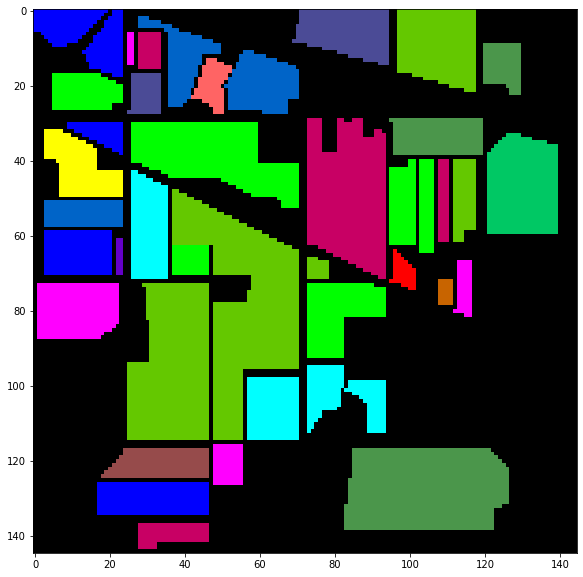

In [71]:
ground_truth = imshow(classes=y, figsize=(10, 10))
ground_truth

In [72]:
# Preprocess Data
XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, 
                                                     y.max()-y.min(), testRatio)
X_all = np.append(X_train, X_test, axis=0)
y_all = np.append(y_train, y_test, axis=0)
X_train, y_train = oversampleWeakClasses(X_train, y_train)
print(y_train.shape)
# X_all, y_all = oversampleWeakClasses(X_all, y_all)
X_train = AugmentData(X_train)
# X_all = AugmentData(X_all)

TRAIN: [2781 6279 3297 ... 5097 4914 8964] TEST: [9084 4074 8765 ... 5807 6894 3023]
TRAIN: [9762 4184 1288 ... 1774 4117 9458] TEST: [7558 5539 7520 ... 9634 8226 1214]
TRAIN: [ 6181  4966  5682 ...  7371  9168 10179] TEST: [ 365 6960 4462 ... 4461 5348 9490]
TRAIN: [ 524 6368 9843 ... 4748 3740 6226] TEST: [7370 4467 6938 ... 9257 9670 3850]
TRAIN: [7774  929 1779 ... 1812 8760 7467] TEST: [2613 5255 6617 ... 6102 1677 1270]
TRAIN: [8792  188 9644 ... 4201 6541  334] TEST: [7302 6714 1305 ... 5907 1646 2514]
TRAIN: [2570 3125 1351 ... 1440 2466 2590] TEST: [6309 6106 5418 ... 9067 9133 6891]
TRAIN: [1476 7519 8645 ... 9738 7632 7565] TEST: [9276 1017 7027 ... 4251  773  912]
TRAIN: [1395 1189 7202 ... 6329 4528 7629] TEST: [6627  423 6973 ... 6191  943 2590]
TRAIN: [2571   56 3512 ... 7903 3706 3749] TEST: [7619 7003 7977 ... 9377 5280  980]
TRAIN: [1398 7438  995 ... 5524 8306  696] TEST: [ 690 6741 9688 ... 7389 9343 3096]
TRAIN: [2647  795 7710 ... 5010 1338 9358] TEST: [  836   9

# save Preprocessed Data to file
savePreprocessedData('predata', X_train, X_test, y_train, y_test, 
                     X_all, y_all, windowSize = windowSize, 
                     wasPCAapplied=True, numPCAComponents = numComponents, 
                     testRatio = testRatio)

<h1>2. TRAINING <h1

In [0]:
# load Preprocessed data from file
X_train = np.load("/content/drive/My Drive/Indian_pines_classification-master/predata/XtrainWindowSize" 
                  + str(windowSize) + "PCA" + str(numPCAcomponents) + 
                  "testRatio" + str(testRatio)  + ".npy")
y_train = np.load("/content/drive/My Drive/Indian_pines_classification-master/predata/ytrainWindowSize" 
                  + str(windowSize) + "PCA" + str(numPCAcomponents) + 
                  "testRatio" + str(testRatio) + ".npy")
X_test = np.load("/content/drive/My Drive/Indian_pines_classification-master/predata/XtestWindowSize" 
                  + str(windowSize) + "PCA" + str(numPCAcomponents) + 
                 "testRatio" + str(testRatio)  + ".npy")
y_test = np.load("/content/drive/My Drive/Indian_pines_classification-master/predata/ytestWindowSize" 
                  + str(windowSize) + "PCA" + str(numPCAcomponents) + 
                 "testRatio" + str(testRatio) + ".npy")

In [74]:
# Reshape data into (numberofsumples, channels, height, width)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[3], 
                               X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[3], 
                             X_test.shape[1], X_test.shape[2]))

# convert class labels to on-hot encoding
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# Define the input shape 
input_shape= X_train[0].shape
print(input_shape)

# number of filters
C1 = 3*numPCAcomponents

(30, 5, 5)


In [0]:
# Define the model structure
model = Sequential()

model.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(3*C1, (3, 3), activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(6*numPCAcomponents, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))

In [0]:
# Define optimization and train method
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, 
                              min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="checkpoint.hdf5", verbose=1, 
                              save_best_only=True)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
                              metrics=['accuracy'])

In [0]:
import os.path
from os import path
from keras.models import load_model
if(path.exists('/content/drive/My Drive/Indian_pines_classification-master/model/HSI_model_epochs100.h5')):
    # load the model architecture and weights
    model = load_model('/content/drive/My Drive/Indian_pines_classification-master/model/HSI_model_epochs100.h5')
else:
    
    # Start to train model 
    history = model.fit(X_train, y_train, 
                        batch_size=32, 
                        epochs=100, 
                        verbose=1, 
                        validation_data=(X_test, y_test),
                        callbacks=[reduce_lr, checkpointer],
                        shuffle=True)
    # save the model with h5py
    import h5py
    model.save('/content/drive/My Drive/Indian_pines_classification-master/model/HSI_model_epochs100.h5')

In [78]:
"""import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
plt.savefig("/content/drive/My Drive/Indian_pines_classification-master/result/model_accuracy_100.svg")
plt.show()

# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'test'], loc='upper left') 
plt.savefig("/content/drive/My Drive/Indian_pines_classification-master/result/model_loss_100.svg")
plt.show()"""

'import matplotlib.pyplot as plt\n# summarize history for accuracy\nplt.plot(history.history[\'accuracy\'])\nplt.plot(history.history[\'val_accuracy\'])\nplt.title(\'model accuracy\')\nplt.ylabel(\'accuracy\')\nplt.xlabel(\'epoch\')\nplt.grid(True)\nplt.legend([\'train\', \'test\'], loc=\'upper left\') \nplt.savefig("/content/drive/My Drive/Indian_pines_classification-master/result/model_accuracy_100.svg")\nplt.show()\n\n# summarize history for loss \nplt.plot(history.history[\'loss\'])\nplt.plot(history.history[\'val_loss\'])\nplt.title(\'model loss\')\nplt.ylabel(\'loss\')\nplt.xlabel(\'epoch\')\nplt.grid(True)\nplt.legend([\'train\', \'test\'], loc=\'upper left\') \nplt.savefig("/content/drive/My Drive/Indian_pines_classification-master/result/model_loss_100.svg")\nplt.show()'

<h1>3. TESTING CNN_MODEL ON INDIAN_PINES<h1

In [0]:
# Get the model evaluation report, 
# include classification report, confusion matrix, Test_Loss, Test_accuracy
target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
           ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
            'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
           'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
           'Stone-Steel-Towers']
def reports(X_test,y_test):
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss = score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy

In [0]:
def Patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [0]:
# Read PreprocessedData from file

X_test = np.load("/content/drive/My Drive/Indian_pines_classification-master/predata/XtestWindowSize" 
                 + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
y_test = np.load("/content/drive/My Drive/Indian_pines_classification-master/predata/ytestWindowSize" 
                + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")

# X_test = np.load("./predata/XAllWindowSize" 
#                  + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
# y_test = np.load("./predata/yAllWindowSize" 
#                  + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[3], X_test.shape[1], X_test.shape[2]))
y_test = np_utils.to_categorical(y_test)

In [82]:
# load the model architecture and weights
model = load_model('/content/drive/My Drive/Indian_pines_classification-master/model/HSI_model_epochs100.h5')

# calculate result, loss, accuray and confusion matrix
classification, confusion, Test_loss, Test_accuracy = reports(X_test,y_test)
classification = str(classification)
confusion_str = str(confusion)

# show result and save to file
print('Test loss {} (%)'.format(Test_loss))
print('Test accuracy {} (%)'.format(Test_accuracy))
print("classification result: ")
print('{}'.format(classification))
print("confusion matrix: ")
print('{}'.format(confusion_str))
file_name = '/content/drive/My Drive/Indian_pines_classification-master/result/report' + "WindowSize" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) +".txt"
with open(file_name, 'w') as x_file:
    x_file.write('Test loss {} (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('Test accuracy {} (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write(" classification result: \n")
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write(" confusion matrix: \n")
    x_file.write('{}'.format(confusion_str))

5125/5125 [==============================] - 0s 85us/step
Test loss 11.077157998888536 (%)
Test accuracy 97.26829528808594 (%)
classification result: 
                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.96      0.98        23
                 Corn-notill       0.97      0.93      0.95       714
                Corn-mintill       0.95      0.98      0.97       415
                        Corn       0.97      0.93      0.95       118
               Grass-pasture       1.00      0.98      0.99       242
                 Grass-trees       0.99      0.98      0.98       365
         Grass-pasture-mowed       1.00      1.00      1.00        14
               Hay-windrowed       1.00      1.00      1.00       239
                        Oats       1.00      1.00      1.00        10
              Soybean-notill       0.97      0.96      0.97       486
             Soybean-mintill       0.97      0.99      0.98      1228
        

Confusion matrix, without normalization
[[  22    0    0    0    0    0    0    1    0    0    0    0    0    0
     0    0]
 [   0  662   14    0    0    0    0    0    0    6   24    8    0    0
     0    0]
 [   0    4  406    0    0    0    0    0    0    0    5    0    0    0
     0    0]
 [   0    5    2  110    0    0    0    0    0    0    0    1    0    0
     0    0]
 [   0    0    0    3  236    0    0    0    0    0    0    1    0    0
     2    0]
 [   0    0    0    0    0  358    0    0    0    0    0    0    0    0
     7    0]
 [   0    0    0    0    0    0   14    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0  239    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   10    0    0    0    0    0
     0    0]
 [   0    1    3    0    0    1    0    0    0  468   12    0    0    1
     0    0]
 [   0    7    0    0    0    0    0    0    0    3 1212    4    0    0
     0    2]
 [   0    0    1    0    

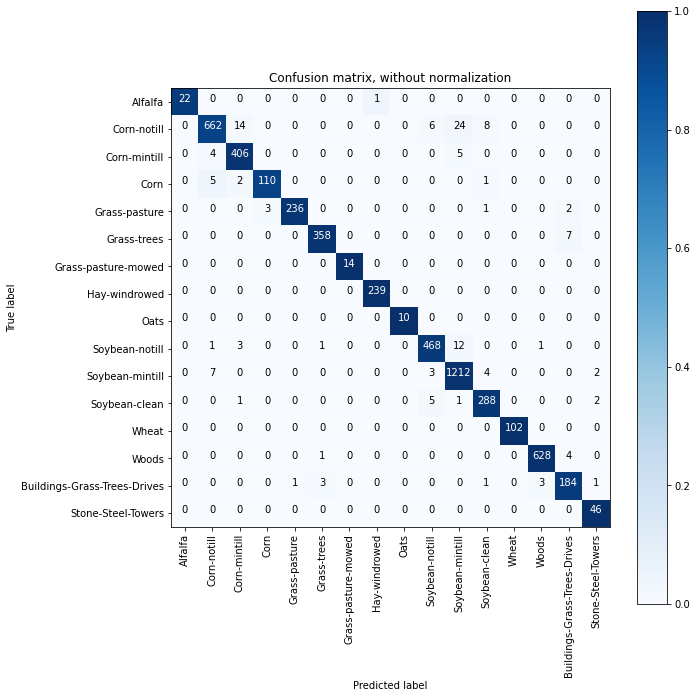

Normalized confusion matrix
[[0.95652174 0.         0.         0.         0.         0.
  0.         0.04347826 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.92717087 0.01960784 0.         0.         0.
  0.         0.         0.         0.00840336 0.03361345 0.01120448
  0.         0.         0.         0.        ]
 [0.         0.00963855 0.97831325 0.         0.         0.
  0.         0.         0.         0.         0.01204819 0.
  0.         0.         0.         0.        ]
 [0.         0.04237288 0.01694915 0.93220339 0.         0.
  0.         0.         0.         0.         0.         0.00847458
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.01239669 0.97520661 0.
  0.         0.         0.         0.         0.         0.00413223
  0.         0.         0.00826446 0.        ]
 [0.         0.         0.         0.         0.         0.98082192
  0.         0.         0.         0.        

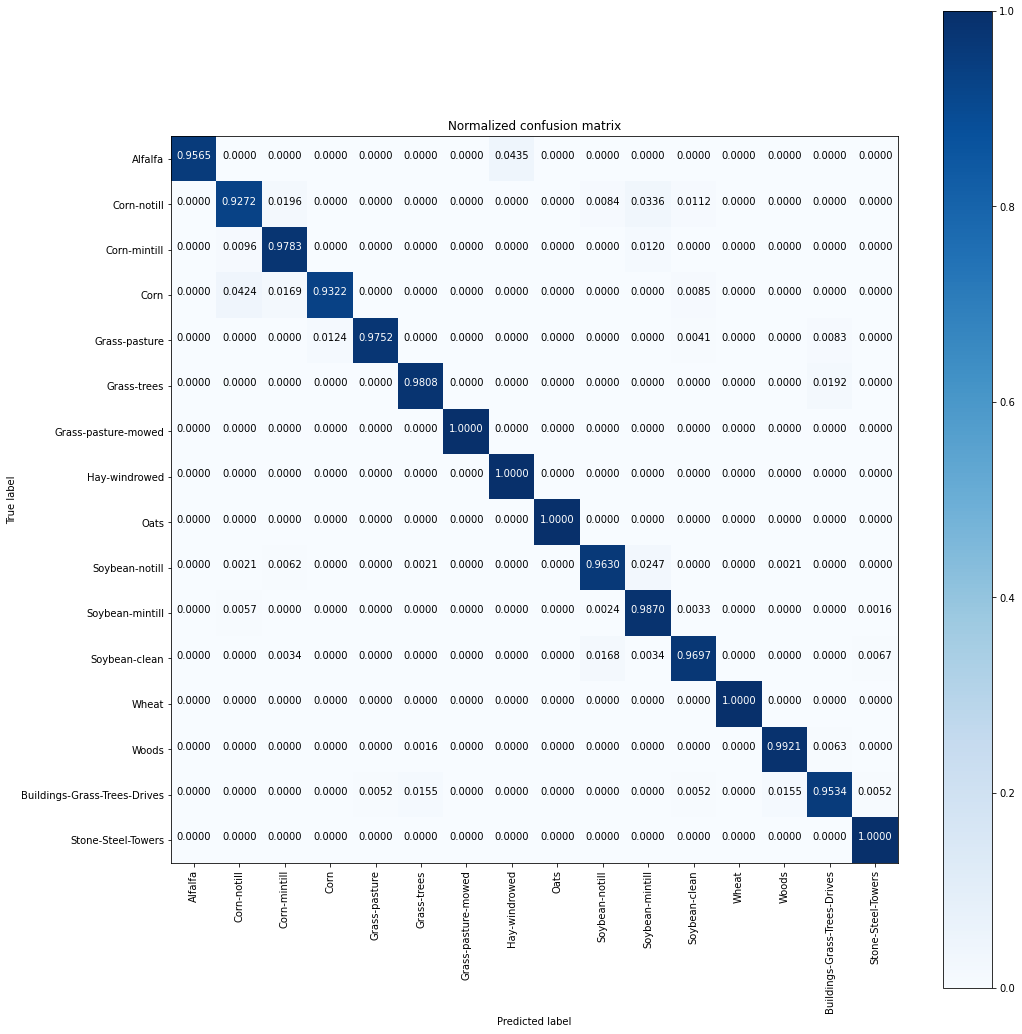

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.get_cmap("Blues")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if normalize:
        cm = Normalized
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(Normalized, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        thresh = cm[i].max() / 2.
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion, classes=target_names, normalize=False, 
                      title='Confusion matrix, without normalization')
plt.savefig("/content/drive/My Drive/Indian_pines_classification-master/result/confusion_matrix_without_normalization.svg")
plt.show()
plt.figure(figsize=(15,15))
plot_confusion_matrix(confusion, classes=target_names, normalize=True, 
                      title='Normalized confusion matrix')
plt.savefig("/content/drive/My Drive/Indian_pines_classification-master/result/confusion_matrix_with_normalization.svg")
plt.show()

In [0]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = 5
numComponents = 30

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height-PATCH_SIZE+1):
    for j in range(width-PATCH_SIZE+1):
        p = int(PATCH_SIZE/2)
        # print(y[i+p][j+p])
        # target = int(y[i+PATCH_SIZE/2, j+PATCH_SIZE/2])
        target = y[i+p][j+p]
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            # print (image_patch.shape)
            X_test_image = image_patch.reshape(1,image_patch.shape[2],image_patch.shape[0],image_patch.shape[1]).astype('float32')                                   
            prediction = (model.predict_classes(X_test_image))                         
            outputs[i+p][j+p] = prediction+1

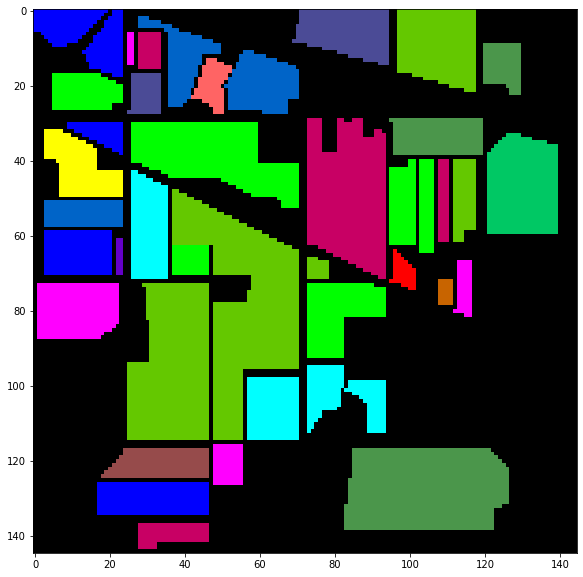

In [85]:
ground_truth = imshow(classes=y, figsize=(10, 10))

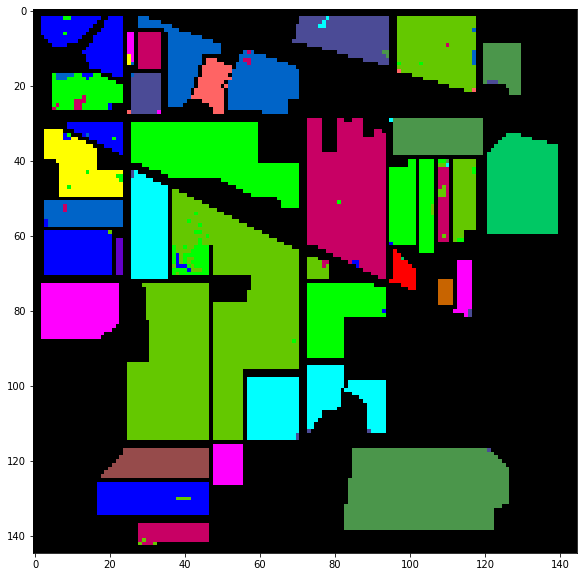

In [86]:
predict_image = imshow(classes=outputs.astype(int), figsize=(10, 10))